In [1]:
# pip install torch torchvision matplotlib

#Loading the Requirements

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

#Loading the pre-trained ResNet-18 model

In [3]:
# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True).eval()

# Preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

c:\Users\Bhavesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Bhavesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#Loading and Preprocessing Image

In [13]:
# Load and preprocess the image
image_path = r"D:\web dev backup\Pytorch\data\cifar10\test\cat\0001.png"
image = Image.open(image_path)  # Replace with the path to your image
image_tensor = preprocess(image).unsqueeze(0)

# Helper function to get prediction
def get_prediction(image_tensor):
    output = model(image_tensor)
    _, pred = output.max(1)
    return pred.item(), torch.nn.functional.softmax(output, dim=1)[0, pred].item()

# Load ImageNet labels
imagenet_labels = np.array(open("cifar_10_data_class.txt").read().splitlines())
original_label, original_confidence = get_prediction(image_tensor)

original_confidence , original_label

(0.13270407915115356, 335)

Visualization

In [14]:
# Function to visualize original and perturbed images
def plot_images(original, perturbed, attack_name, orig_label, pert_label):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(np.transpose(original.squeeze().cpu().detach().numpy(), (1, 2, 0)))
    axes[0].set_title(f"Original Image\nLabel: {imagenet_labels[orig_label]}")
    axes[1].imshow(np.transpose(perturbed.squeeze().cpu().detach().numpy(), (1, 2, 0)))
    axes[1].set_title(f"{attack_name} Attack\nLabel: {imagenet_labels[pert_label]}")
    for ax in axes:
        ax.axis("off")
    plt.show()

#FGSM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7069099..2.5702832].


IndexError: index 335 is out of bounds for axis 0 with size 1

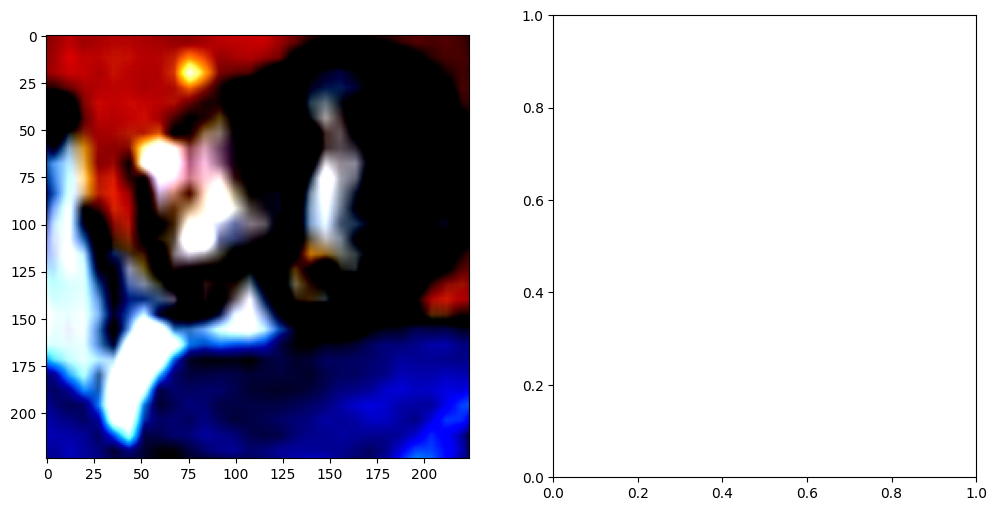

In [15]:
# FGSM Attack
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# FGSM Attack
epsilon = 0.007
image_tensor.requires_grad = True
output = model(image_tensor)
loss = F.cross_entropy(output, torch.tensor([original_label]))
model.zero_grad()
loss.backward()
data_grad = image_tensor.grad.data
fgsm_image = fgsm_attack(image_tensor, epsilon, data_grad)
fgsm_label, _ = get_prediction(fgsm_image)
plot_images(image_tensor, fgsm_image, "FGSM", original_label, fgsm_label)



#BIM Attack

In [ ]:
# BIM Attack (iterative FGSM)
def bim_attack(image, epsilon, alpha, num_iter, target_label):
    perturbed_image = image.clone()
    for _ in range(num_iter):
        perturbed_image_clone = perturbed_image.clone().detach()
        perturbed_image_clone.requires_grad = True

        output = model(perturbed_image_clone)
        loss = F.cross_entropy(output, target_label)
        model.zero_grad()
        loss.backward()
        data_grad = perturbed_image_clone.grad.data

        perturbed_image = perturbed_image_clone + alpha * data_grad.sign()
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        perturbed_image = perturbed_image.detach()
    return perturbed_image

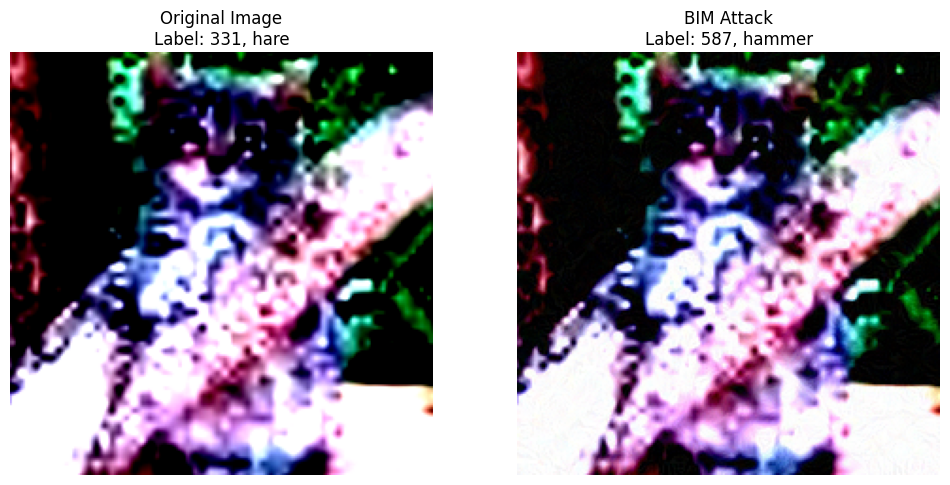

In [ ]:
# BIM Attack
alpha = 0.005
num_iter = 10
target_label = torch.tensor([original_label])
bim_image = bim_attack(image_tensor, epsilon, alpha, num_iter, target_label)
bim_label, _ = get_prediction(bim_image)
plot_images(image_tensor, bim_image, "BIM", original_label, bim_label)

#PGD

In [ ]:
def pgd_attack(image, epsilon, alpha, num_iter, target_label):
    # Create a copy of the image with requires_grad=True
    perturbed_image = image.clone().detach()
    perturbed_image.requires_grad = True

    # Add uniform noise to the image
    perturbed_image = perturbed_image + torch.empty_like(perturbed_image).uniform_(-epsilon, epsilon)
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    perturbed_image = perturbed_image.detach()  # Detach to make it a leaf

    for _ in range(num_iter):
        perturbed_image.requires_grad = True  # Set requires_grad for each iteration
        output = model(perturbed_image)
        loss = F.cross_entropy(output, target_label)
        model.zero_grad()
        loss.backward()
        data_grad = perturbed_image.grad.data
        perturbed_image = perturbed_image + alpha * data_grad.sign()
        perturbed_image = torch.clamp(perturbed_image, image - epsilon, image + epsilon)
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        perturbed_image = perturbed_image.detach()  # Detach to make it a leaf
    return perturbed_image

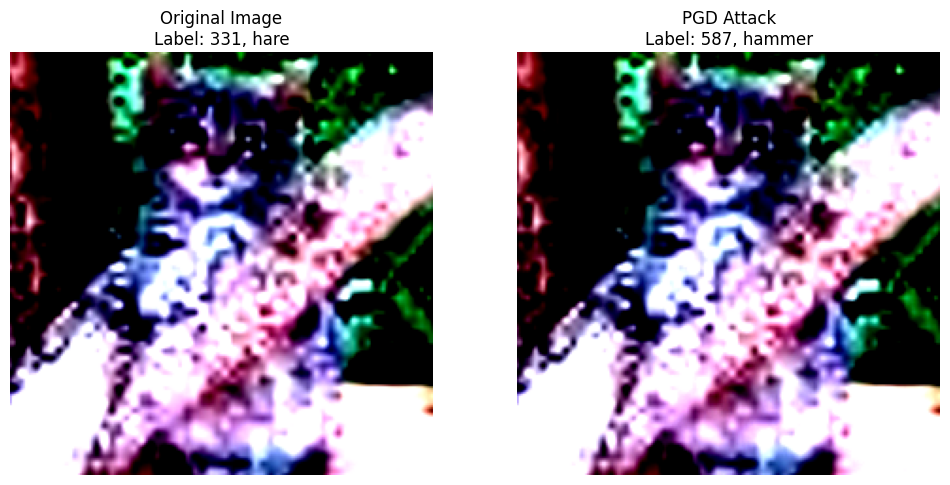

In [ ]:
# PGD Attack
pgd_image = pgd_attack(image_tensor, epsilon, alpha, num_iter, target_label)
pgd_label, _ = get_prediction(pgd_image)
plot_images(image_tensor, pgd_image, "PGD", original_label, pgd_label)

#C&W

In [ ]:
def cw_attack(image, num_iter, c, lr, target_label):
    # Create a copy of the image with data and set requires_grad=True
    perturbed_image = image.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([perturbed_image], lr=lr)
    for _ in range(num_iter):
        output = model(perturbed_image)
        real = output[0, target_label]
        other = output[0, [i for i in range(len(output[0])) if i != target_label]].max()
        loss = c * (real - other)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        # Instead of in-place modification, create a new tensor:
        perturbed_image = perturbed_image.detach().clone().requires_grad_(True)
    return perturbed_image

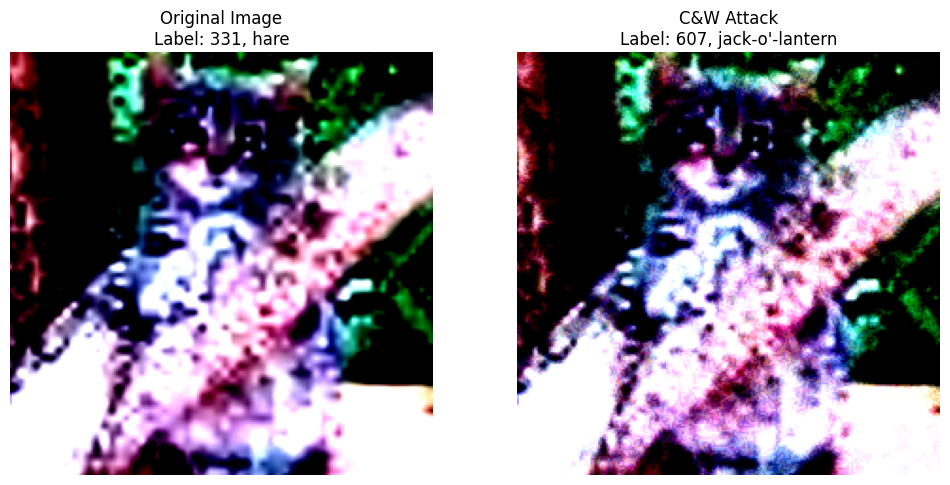

In [ ]:
# CW Attack
c = 1e-4  # Hyper parameter
lr = 0.1 # Learning rate
num_iter = 20
cw_image = cw_attack(image_tensor, num_iter, c, lr, original_label)
cw_label, _ = get_prediction(cw_image)
plot_images(image_tensor, cw_image, "C&W", original_label, cw_label)